In [163]:
%run GraphFamilies.ipynb
from IPython.display import clear_output

In [205]:
# Get list of graphs from graph families

#SETTINGS:
# Higher settings will increase accuracy but result in slower runtime

# Maximum size hole to include
maxhole = 10

# Maximum length path to include
maxpath = 5

# TRUE: Use connected graph families
# FALSE: Use disconnected graph familise
connected = True 

#############
graph_family_list = AllFamilies(maxhole, maxpath, connected)
print(f"{len(graph_family_list)} graphs included for testing")

1722 graphs included for testing


In [206]:
# Helper functions

def get_all_subgraphs(G):
    G_sg_list = []

    for vertex_subset in Subsets(G.vertices()):
            current_sg = G.subgraph(vertex_subset)

            add_flag = True
            for H in G_sg_list:
                if (current_sg.order() != H.order()) or (current_sg.size() != H.size()): #Different number of vertices/edges, no need to test isomorphism
                    continue
                elif H.is_isomorphic(current_sg):
                    add_flag = False
                    break 
            
            if add_flag == True:
                G_sg_list.append(current_sg)
    
    return G_sg_list

def get_best_sgs(graph_list = graph_family_list):
    # Need only to test graphs know contained in graph with the least subgraphs
    # Estimate using number of vertices
    # Find this graph
    best_order = 1000000
    for i in graph_list:
        current_order = i.order()
        if current_order < best_order:
            best_order = current_order
            best_graph = i
    
    return best_graph

def remove_redundant(tuple_list):
    cleaned_list = deepcopy(tuple_list)

    for i in tuple_list:
        for j in tuple_list:
            if tuple_list.index(i) == tuple_list.index(j): continue

            i_checklist = 0
            for x in i:
                for y in j:
                    if x.subgraph_search(y, induced=True) is not None:
                        i_checklist = i_checklist + 1
                        break
            
            if i_checklist == len(i):
                if j in cleaned_list: cleaned_list.remove(j)

    
    return cleaned_list



In [207]:
# Find classification for single induced subgraph

def find_forbidden_1(graph_list = graph_family_list,exclusions=[]):
    forbidden_graphs = []
    test_sg_list = get_all_subgraphs(get_best_sgs(graph_list))
    
    # Order list of subgraphs we need to test by most vertices first
    test_sg_list.sort(reverse = True, key=order)

    # Check each 
    for test_sg in test_sg_list:
        add_flag = True

        # Make sure graph isn't excluded
        for exclusion in exclusions:
            if exclusion.subgraph_search(test_sg, induced=True) is not None:
                add_flag = False
                break
        if add_flag == False: continue
        
        # Make sure subgraph isn't already contained in a graph already included (most vertices first means this test is simple)
        for already_seen in forbidden_graphs:
            if already_seen.subgraph_search(test_sg, induced=True) is not None:
                add_flag = False
                break
        if add_flag == False: continue
        
        # Look at each graph in each family
        for current_graph in graph_list:
            if current_graph.subgraph_search(test_sg, induced=True) is None:
                add_flag = False
                break
            
        
        # Include subgraph only if found as a subgraph in all graphs
        if add_flag == True:
            forbidden_graphs.append(test_sg)
    
    return(forbidden_graphs)


forbidden_graphs_1 = find_forbidden_1()
print(forbidden_graphs_1)

[Subgraph of (): Graph on 4 vertices, Subgraph of (): Graph on 3 vertices]


In [208]:
# Find classification for two induced subgraphs
def find_forbidden_2(graph_list = graph_family_list,exclusions=[]):
    #debug_counter = 0
    forbidden_graph_pairs = []

    test_first_sg_list = get_all_subgraphs(get_best_sgs(graph_list))
    
    # Order list of subgraphs we need to test by most vertices first
    test_first_sg_list.sort(reverse = True, key=order)

    # Check each 
    for test_sg in test_first_sg_list:
        add_flag = True

        # Check that isn't in the monogenic case
        for case_1 in forbidden_graphs_1:
            if case_1.subgraph_search(test_sg, induced=True) is not None:
                add_flag = False
                break
        if add_flag == False: continue

        # Create a new list by removing all graphs containing our subgraph
        culled_graph_list = deepcopy(graph_list)
        for current_graph in graph_list:
            good_flag = False

            # Check if the subgraph we're testing appears as a subgraph in this graph
            if current_graph.subgraph_search(test_sg, induced=True) is not None:
                good_flag = True
            
            # If it does, remove it from our new list
            if good_flag == True:
                culled_graph_list.remove(current_graph)
        
        # Find single graphs which are in all graphs of this new table but not in the monogenic case
        if culled_graph_list == []: continue
        second_graphs = find_forbidden_1(culled_graph_list,forbidden_graphs_1)
 
        # Add pairs
        for second_graph in second_graphs:
            # Make sure pair isn't in exclusions
            exclusion_flag = False
            for exclusion in exclusions:
                if (exclusion[0].subgraph_search(test_sg, induced=True) is not None) and (exclusion[1].subgraph_search(second_graph, induced=True) is not None) or \
                   (exclusion[1].subgraph_search(test_sg, induced=True) is not None) and (exclusion[0].subgraph_search(second_graph, induced=True) is not None):
                    exclusion_flag = True

            if exclusion_flag == False: forbidden_graph_pairs.append([test_sg,second_graph])
    
    forbidden_graph_pairs_cleaned = remove_redundant(forbidden_graph_pairs)
    
    #print(debug_counter)
    return forbidden_graph_pairs_cleaned

forbidden_graphs_2 = find_forbidden_2()
print(forbidden_graphs_2)

    

[[Subgraph of (): Graph on 5 vertices, Subgraph of (): Graph on 4 vertices], [Subgraph of (): Graph on 5 vertices, Subgraph of (): Graph on 4 vertices], [Subgraph of (): Graph on 4 vertices, Subgraph of (): Graph on 6 vertices], [Subgraph of (): Graph on 4 vertices, Subgraph of (): Graph on 8 vertices], [Subgraph of (): Graph on 4 vertices, Subgraph of (): Graph on 9 vertices], [Subgraph of (): Graph on 4 vertices, Subgraph of (): Graph on 5 vertices]]


In [209]:
# Find classification for three induced subgraphs
def find_forbidden_3(graph_list = graph_family_list,exclusions=[]):
    #debug_counter = 0
    forbidden_graph_triples = []

    test_first_sg_list = get_all_subgraphs(get_best_sgs(graph_list))
    
    # Order list of subgraphs we need to test by most vertices first
    test_first_sg_list.sort(reverse = True, key=order)

    # Check each 
    for test_sg in test_first_sg_list:
        add_flag = True

        # Check that isn't in the monogenic case
        for case_1 in forbidden_graphs_1:
            if case_1.subgraph_search(test_sg, induced=True) is not None:
                add_flag = False
                break
        if add_flag == False: continue

        # Create a new list by removing all graphs containing our subgraph
        culled_graph_list = deepcopy(graph_list)
        for current_graph in graph_list:
            good_flag = False

            # Check if the subgraph we're testing appears as a subgraph in this graph
            if current_graph.subgraph_search(test_sg, induced=True) is not None:
                good_flag = True
            
            # If it does, remove it from our new list
            if good_flag == True:
                culled_graph_list.remove(current_graph)
        
        # Find graph pairs which are in all graphs of this new table but not in the monogenic case
        if culled_graph_list == []: continue
        second_graphs = find_forbidden_2(culled_graph_list,forbidden_graphs_2)

        # Add triples
        for second_graph in second_graphs:
            t = [test_sg,second_graph[0],second_graph[1]]
            
            exclusion_flag = False
            for exclusion in exclusions: #TO ADD: Better exclusion checking created alongside redundancy removal
                if (exclusion[0].subgraph_search(t[0], induced=True) is not None) and \
                        (exclusion[1].subgraph_search(t[1], induced=True) is not None) and \
                        (exclusion[2].subgraph_search(t[2], induced=True) is not None) or \
                   (exclusion[0].subgraph_search(t[0], induced=True) is not None) and \
                        (exclusion[1].subgraph_search(t[2], induced=True) is not None) and \
                        (exclusion[2].subgraph_search(t[1], induced=True) is not None) or \
                    (exclusion[0].subgraph_search(t[1], induced=True) is not None) and \
                        (exclusion[1].subgraph_search(t[0], induced=True) is not None) and \
                        (exclusion[2].subgraph_search(t[2], induced=True) is not None) or \
                    (exclusion[0].subgraph_search(t[1], induced=True) is not None) and \
                        (exclusion[1].subgraph_search(t[2], induced=True) is not None) and \
                        (exclusion[2].subgraph_search(t[0], induced=True) is not None) or \
                    (exclusion[0].subgraph_search(t[2], induced=True) is not None) and \
                        (exclusion[1].subgraph_search(t[0], induced=True) is not None) and \
                        (exclusion[2].subgraph_search(t[1], induced=True) is not None) or \
                    (exclusion[0].subgraph_search(t[2], induced=True) is not None) and \
                        (exclusion[1].subgraph_search(t[1], induced=True) is not None) and \
                        (exclusion[2].subgraph_search(t[0], induced=True) is not None):
                    exclusion_flag = True

            if exclusion_flag == False: forbidden_graph_triples.append(t)

    forbidden_graph_triples_cleaned = remove_redundant(forbidden_graph_triples)
            
    return forbidden_graph_triples_cleaned

forbidden_graphs_3 = find_forbidden_3()

In [169]:
# Find classification for four induced subgraphs
def find_forbidden_4(graph_list = graph_family_list,exclusions=[]):
    forbidden_graph_4s = []

    test_first_sg_list = get_all_subgraphs(get_best_sgs(graph_list))
    
    # Order list of subgraphs we need to test by most vertices first
    test_first_sg_list.sort(reverse = True, key=order)

    # Check each 
    for test_sg in test_first_sg_list:
        add_flag = True

        # Check that isn't in the monogenic case
        for case_1 in forbidden_graphs_1:
            if case_1.subgraph_search(test_sg, induced=True) is not None:
                add_flag = False
                break
        if add_flag == False: continue

        # Create a new list by removing all graphs containing our subgraph
        culled_graph_list = deepcopy(graph_list)
        for current_graph in graph_list:
            good_flag = False

            # Check if the subgraph we're testing appears as a subgraph in this graph
            if current_graph.subgraph_search(test_sg, induced=True) is not None:
                good_flag = True
            
            # If it does, remove it from our new list
            if good_flag == True:
                culled_graph_list.remove(current_graph)
        
        # Find graph triples which are in all graphs of this new table but not in the monogenic case
        if culled_graph_list == []: continue
        second_graphs = find_forbidden_3(culled_graph_list,forbidden_graphs_3)

        # Add 4s
        for second_graph in second_graphs:
            t = [test_sg,second_graph[0],second_graph[1],second_graph[2]]
            forbidden_graph_4s.append(t)

    forbidden_graph_4s_cleaned = remove_redundant(forbidden_graph_4s)  

    return forbidden_graph_4s

forbidden_graphs_4 = find_forbidden_4()

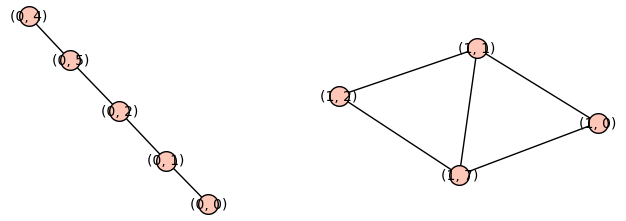

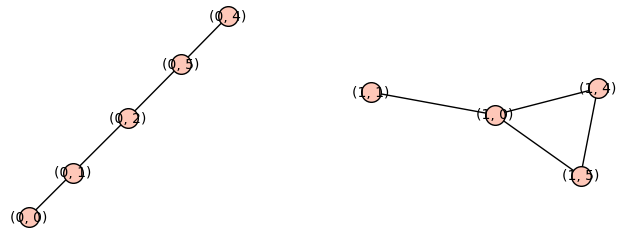

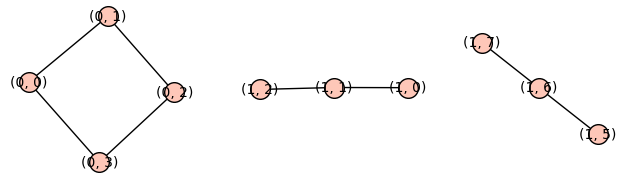

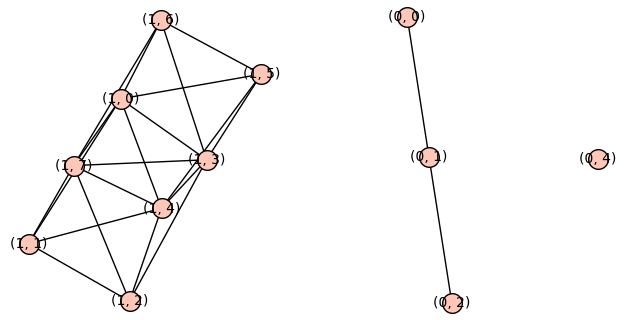

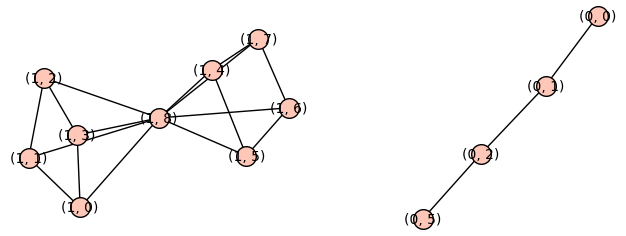

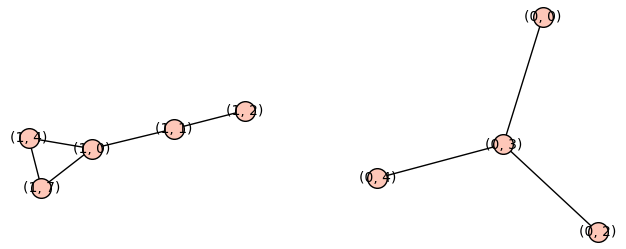

In [204]:
#forbidden_graphs_2_cleaned = remove_redundant(forbidden_graphs_2)


#for i in forbidden_graphs_1:
#    i.plot().show()

for i in forbidden_graphs_2:
    G = i[0].disjoint_union(i[1])
    G.plot().show()
    

#print(forbidden_graphs_3)
#for i in forbidden_graphs_3:
#    G = i[0].disjoint_union(i[1])
#    G = G.disjoint_union(i[2])
#    G.plot().show()